## TYK Battle of the Cities Healthy Food Cafe Pilot Launch Final Project

#### Problem Description and Background

One of our clients <em><b>LiveLong</b></em> has petitioned our firm to gather and analyze some research for healthy food cafes. They are requesting some recommendations on the best cities in which such cafes have the potential to be profitable and have a positive impact in that community. <em><b>LiveLong' s</b></em> goal is to target two cities for launching their initial health food cafes, and checking the results of revenue and positive impact in the community. The criteria is to target neighborhoods that have larger concentrations of venues for healthy choice activities with lowest rate of competition. 

#### Data Description and Approach

Results from a study posted by Adam McCann, February 10, 2020  <a href=" https://wallethub.com/edu/healthiest-cities/31072"/><em><b>Healthiest and Unhealthiest Cities in America</b></em></a> provides rankings for the healthiest and most unhealthy cities in the United States. A further analysis will be done to make a determination of which two cities may be chosen for analysis, according to their total health score rankings. 

The top 25 healthiest cities are chosen from this previous study. 
Within these cities, we gather Foursquare location data for venues that represent healthy choice activities, i.e. gyms and fitness centers, along with other types of eateries in the area. The healthy choice activities will give insight to the potential market in the neighborhoods. The other types of cafes in the area will give insight to potential competitors. 

Of these venues, we gather data to understand visitor ratings. Some data visualizations are presented to give some insights. This information is used to determine a success factor rating of 1 or 0. 1 means that the visitor ratings for a specific venue is equal to or greater than the mean of all ratings. 0 means that the visitor ratings are less than the mean. 

The location data for venues that qualify as successful are visually presented on a map.  

Based on the nature of venues with positive success factor rating, two locations will be recommended for pilot launches of a healthy foods cafe . It is more likely that people who frequent healthy choice activity venues may be the best market for a healthy foods café.

#### Library imports

In [91]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import warnings # to keep the simple warnings from showing up as a result of SettingWithCopyWarning
warnings.filterwarnings('ignore')

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
from sklearn import preprocessing

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # plotting library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
print('Libraries imported.')

Libraries imported.


#### Data Sources

In [2]:
# pull in the dataset to view what city(ies) may be used
# saved dataset from Healthiest and Unhealthiest Cities in the US 
df_cities_selected = pd.read_csv("rank_healthy_cities.csv")
df_cities_selected

,overall_rank,city,total_health_score,health_care_rank,food_rank,fitness_rank,green_space_rank
0,1,"San Francisco, CA",73.99,29,1,4,1
1,2,"Seattle, WA",70.62,19,4,3,2
2,3,"San Diego, CA",70.01,25,3,1,8
3,4,"Portland, OR",65.66,61,6,16,3
4,5,"Washington, DC",63.87,47,9,26,5
...,...,...,...,...,...,...,...
169,170,"Memphis, TN",29.64,166,155,169,160
170,171,"Shreveport, LA",27.42,165,171,171,165
171,172,"Gulfport, MS",24.82,171,172,167,174
172,173,"Laredo, TX",24.06,151,170,174,156


In [15]:
# take the top 25 cities 
df_cities_selected = df_cities_selected.head(25)

df_cities_selected.shape

(25, 7)

In [4]:
#initialize dataframes for use in functions
df_restaurants = pd.DataFrame()
df_fitness = pd.DataFrame()



##### Define all functions that will extract and process data from foursquare and Healthiest Cities sources

In [5]:

#define functions

def get_address(city):
    #get geolocation for city 
        address = city

        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        #print(latitude, longitude, city)
        return(latitude, longitude)
    
# search query function
def search_query (search_item, latitude, longitude):
    search_query = search_item
    radius = 8050  # about 5 mile radius from address location of city
    #print(search_query + ' .... OK!')
    #print('inside of search query function ', latitude, longitude)

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    url
    return url

def get_results_set (url):
    results = requests.get(url).json()
    #print ('inside of get results set')
    return results

In [6]:
#get foursquare data and create the restaurants info dataframe 
# ten cities with 30 row limit, not more than 300 rows 
def get_foursquare_data(df_city_selections, search_item):
    df_results = pd.DataFrame(columns =['id',  
                                               'name', 
                                               'categories', 
                                               'referralId', 
                                              'hasPerk',   
                                               'location.address', 
                                               'location.crossStreet', 
                                               'location.lat',
                                               'location.lng',
                                               'location.labeledLatLngs', 
                                               'location.distance',  
                                               'location.postalCode', 
                                               'location.cc',
                                               'location.city', 
                                               'location.state', 
                                               'location.country',
                                               'location.formattedAddress', 
                                               'delivery.id', 
                                               'delivery.url', 
                                               'delivery.provider.name', 
                                               'delivery.provider.icon.prefix', 
                                               'delivery.provider.icon.sizes', 
                                               'delivery.provider.icon.name', 
                                               'venuePage.id'])
    
    for i in range (df_city_selections['city'].count()):
        lat, long = get_address(df_city_selections.iloc[i,1])
        
        #set up search query for restaurants first 
        search_url = search_query(search_item, lat, long)
        
        #run the query
        result_set = get_results_set(search_url)
        
        # assign relevant part of JSON to venues
        venues = result_set['response']['venues']

         
        # tranform venues into a dataframe
        temp = pd.json_normalize(venues)
        
           
        #append to dataframe with restaurants info for the selected cities
        df_results = df_results.append(temp)
        
        #end for function
        
        
    return df_results

In [7]:

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [8]:
#function for filtering the data from foursquare
def filter_dataframe (df_unfiltered):
        # keep only columns that include venue name, and anything that is associated with location
        filtered_columns = ['name', 'categories'] + [col for col in df_unfiltered.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = df_unfiltered.loc[:, filtered_columns]

        # filter the category for each row
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

        return dataframe_filtered

In [9]:
# function to remove rows from nearby non-US cities 
def remove_nonUS_rows(df):
    df = df[df.country == 'United States']
    return df

# Get Likes functions 
def get_likes_counts(venue_id):
    like_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    like_results = requests.get(like_url).json()
    # assign relevant part of JSON to venues
    likes = like_results['response']['likes']

    # tranform venues into a dataframe
    likes_rec = pd.json_normalize(likes)
    return likes_rec 

# Add Likes count function 

def add_like_counts(passdf):
    for i in range (passdf['id'].count()):
        count_rec = []
        venue_id = passdf.iloc[i,15]  #venue id is in column index 15
        count_rec = get_likes_counts(venue_id)
        passdf.iloc[i,16] = count_rec.iloc[0,0]  #likes_count column index is 16
        #print('{} pass value is {} for venue id {}'.format(i, passdf.iloc[i,24], venue_id))
        

In [10]:
# Function for setting the success_factor field for classification model
def set_success_factor(df):
    for i in range (df['success_factor'].count()):
        if df.iloc[i,16] >= df['likes_count'].mean():
            df.iloc[i, 17] = 1   #sets success_factor to true if likes is >= the mean value
        else:
            df.iloc[i, 17] = 0   #set success_factor to false if less than mean
        #endif
    #end for
    return df

               
                

In [16]:
# create restaurants list from the 25 selected cities 
df_restaurants_unfiltered = get_foursquare_data(df_cities_selected, 'restaurant')

df_restaurants_unfiltered.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id,location.neighborhood
0,4ec5ad8d2c5b532d048e4dc9,Restaurant Le Parfum d'Asie,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1593414929,False,NaN,NaN,46.868422,-71.275051,"[{'label': 'display', 'lat': 46.86842154933377...",...,Canada,"[Québec QC, Canada]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4ba6ae71f964a5207a6839e3,Restaurant Maison de Jade,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1593414929,False,"475, boul de l'Atrium",NaN,46.845527,-71.265193,"[{'label': 'display', 'lat': 46.845527, 'lng':...",...,Canada,"[475, boul de l'Atrium, Québec QC G1H 7H9, Can...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,513e1905e4b0cc27b5577912,Restaurant au Toit Rouge,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1593414929,False,"12025, boul Henri-Bourassa",NaN,46.874404,-71.281330,"[{'label': 'display', 'lat': 46.87440388897072...",...,Canada,"[12025, boul Henri-Bourassa, Québec QC G1G 3Y2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4f2fd337e4b062ad2d783f8d,Restaurant Casa Corsica,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1593414929,False,"6700, Pierre-Bertrand",NaN,46.841932,-71.287868,"[{'label': 'display', 'lat': 46.84193213656866...",...,Canada,"[6700, Pierre-Bertrand, Québec QC G2J 0B4, Can...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4c3de7606faac9b6a8710d76,Restaurant Le Prében,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",v-1593414929,False,"670, rue Bouvier",NaN,46.835213,-71.273375,"[{'label': 'display', 'lat': 46.83521287374423...",...,Canada,"[670, rue Bouvier, Québec QC G2J 1A7, Canada]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_restaurants_unfiltered.shape

(690, 25)

In [18]:
# create fitness centers list from the 25 selected cities 
df_fitness_unfiltered = get_foursquare_data(df_cities_selected, 'fitness')

df_fitness_unfiltered.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id,location.neighborhood
0,4e7bdcbad4c0cd592a23152a,Fitness L'Entrepôt,[],v-1593415038,False,355 rue du Marais,NaN,46.828639,-71.280998,"[{'label': 'display', 'lat': 46.828639, 'lng':...",...,Canada,"[355 rue du Marais, Quebec QC G1M 3N8, Canada]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4e0b6a92cc3f0e8737caf194,Nutrition Sports Fitness,"[{'id': '50aa9e744b90af0d42d5de0e', 'name': 'H...",v-1593415038,False,1041 boul Pierre-Bertrand,NaN,46.828173,-71.276305,"[{'label': 'display', 'lat': 46.828173, 'lng':...",...,Canada,"[1041 boul Pierre-Bertrand, Québec QC G1M 2E8,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4d18f6e5bb64224bb128cb65,Club Piscine Super Fitness,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",v-1593415038,False,"687, boul Pierre-Bertrand",NaN,46.821982,-71.271083,"[{'label': 'display', 'lat': 46.82198152527717...",...,Canada,"[687, boul Pierre-Bertrand, Québec QC G1M 2E4,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5abc1d33a6fe4d09e70e9d12,Yoga Fitness,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1593415038,False,1100 Rue Bouvier Local 320,NaN,46.829342,-71.285723,"[{'label': 'display', 'lat': 46.829342, 'lng':...",...,Canada,"[1100 Rue Bouvier Local 320, Québec QC G2K, Ca...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56988367498e3255b953025c,Univers Gym Fitness,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1593415038,False,4250 1iere Avenue,NaN,46.843676,-71.247272,"[{'label': 'display', 'lat': 46.843676, 'lng':...",...,Canada,"[4250 1iere Avenue, Québec QC G1H 2S5, Canada]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_fitness_unfiltered.shape

(679, 25)

#### Data Pre-processing Section

##### Run the function to filter dataframes for use moving forward

In [20]:
df_restaurants = filter_dataframe(df_restaurants_unfiltered)

df_fitness = filter_dataframe(df_fitness_unfiltered)

print(df_restaurants.shape)
print(df_fitness.shape)

(690, 16)
(679, 16)


In [21]:
#check dataframes
df_restaurants

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Restaurant Le Parfum d'Asie,Asian Restaurant,NaN,NaN,46.868422,-71.275051,"[{'label': 'display', 'lat': 46.86842154933377...",2682,NaN,CA,Québec,QC,Canada,"[Québec QC, Canada]",NaN,4ec5ad8d2c5b532d048e4dc9
1,Restaurant Maison de Jade,Chinese Restaurant,"475, boul de l'Atrium",NaN,46.845527,-71.265193,"[{'label': 'display', 'lat': 46.845527, 'lng':...",708,G1H 7H9,CA,Québec,QC,Canada,"[475, boul de l'Atrium, Québec QC G1H 7H9, Can...",NaN,4ba6ae71f964a5207a6839e3
2,Restaurant au Toit Rouge,Restaurant,"12025, boul Henri-Bourassa",NaN,46.874404,-71.281330,"[{'label': 'display', 'lat': 46.87440388897072...",3390,G1G 3Y2,CA,Québec,QC,Canada,"[12025, boul Henri-Bourassa, Québec QC G1G 3Y2...",NaN,513e1905e4b0cc27b5577912
3,Restaurant Casa Corsica,Restaurant,"6700, Pierre-Bertrand",NaN,46.841932,-71.287868,"[{'label': 'display', 'lat': 46.84193213656866...",1064,G2J 0B4,CA,Québec,QC,Canada,"[6700, Pierre-Bertrand, Québec QC G2J 0B4, Can...",NaN,4f2fd337e4b062ad2d783f8d
4,Restaurant Le Prében,Steakhouse,"670, rue Bouvier",NaN,46.835213,-71.273375,"[{'label': 'display', 'lat': 46.83521287374423...",1016,G2J 1A7,CA,Québec,QC,Canada,"[670, rue Bouvier, Québec QC G2J 1A7, Canada]",NaN,4c3de7606faac9b6a8710d76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Mary's Restaurant,American Restaurant,616 Virginia Beach Blvd,NaN,36.844174,-75.981919,"[{'label': 'display', 'lat': 36.84417392052952...",1059,23451,US,Virginia Beach,VA,United States,"[616 Virginia Beach Blvd, Virginia Beach, VA 2...",NaN,4b9143e5f964a5204cae33e3
26,Bella Monte Restaurant & Enoteca,Italian Restaurant,1201 Laskin Rd,NaN,36.853644,-75.996828,"[{'label': 'display', 'lat': 36.85364438966937...",1730,23451,US,Virginia Beach,VA,United States,"[1201 Laskin Rd, Virginia Beach, VA 23451, Uni...",NaN,4b880638f964a520c4d931e3
27,Honeybee Pancake House,Breakfast Spot,2400 Atlantic Ave,24th Street,36.851871,-75.976078,"[{'label': 'display', 'lat': 36.85187088048554...",172,23451,US,Virginia Beach,VA,United States,"[2400 Atlantic Ave (24th Street), Virginia Bea...",NaN,4bbf3a9430c99c74bfcb5411
28,Jade Garden Chinese Restaurant,Chinese Restaurant,1077 Virginia Beach Blvd,NaN,36.840458,-75.994972,"[{'label': 'display', 'lat': 36.84045791625976...",2095,23451,US,Virginia Beach,VA,United States,"[1077 Virginia Beach Blvd, Virginia Beach, VA ...",NaN,5949aedc3b4e005e30cd60fd


In [22]:
df_fitness

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Fitness L'Entrepôt,None,355 rue du Marais,NaN,46.828639,-71.280998,"[{'label': 'display', 'lat': 46.828639, 'lng':...",1818,G1M 3N8,CA,Québec,QC,Canada,"[355 rue du Marais, Quebec QC G1M 3N8, Canada]",NaN,4e7bdcbad4c0cd592a23152a
1,Nutrition Sports Fitness,Health Food Store,1041 boul Pierre-Bertrand,NaN,46.828173,-71.276305,"[{'label': 'display', 'lat': 46.828173, 'lng':...",1804,G1M 2E8,CA,Québec,QC,Canada,"[1041 boul Pierre-Bertrand, Québec QC G1M 2E8,...",NaN,4e0b6a92cc3f0e8737caf194
2,Club Piscine Super Fitness,Sporting Goods Shop,"687, boul Pierre-Bertrand",NaN,46.821982,-71.271083,"[{'label': 'display', 'lat': 46.82198152527717...",2499,G1M 2E4,CA,Québec,QC,Canada,"[687, boul Pierre-Bertrand, Québec QC G1M 2E4,...",NaN,4d18f6e5bb64224bb128cb65
3,Yoga Fitness,Yoga Studio,1100 Rue Bouvier Local 320,NaN,46.829342,-71.285723,"[{'label': 'display', 'lat': 46.829342, 'lng':...",1880,G2K,CA,Québec,QC,Canada,"[1100 Rue Bouvier Local 320, Québec QC G2K, Ca...",NaN,5abc1d33a6fe4d09e70e9d12
4,Univers Gym Fitness,Gym / Fitness Center,4250 1iere Avenue,NaN,46.843676,-71.247272,"[{'label': 'display', 'lat': 46.843676, 'lng':...",2061,G1H 2S5,CA,Québec,QC,Canada,"[4250 1iere Avenue, Québec QC G1H 2S5, Canada]",NaN,56988367498e3255b953025c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Onelife Fitness - VA Beach Blvd Gym,Gym / Fitness Center,2844 Virginia Beach Blvd,North Lynnhaven Road,36.845457,-76.069414,"[{'label': 'display', 'lat': 36.84545670171272...",8237,23452,US,Virginia Beach,VA,United States,[2844 Virginia Beach Blvd (North Lynnhaven Roa...,NaN,501c7419e4b0a0a8ffe813c1
26,schlaaang sounds 24 hr fitness & gym,Surf Spot,NaN,NaN,36.831614,-76.002154,"[{'label': 'display', 'lat': 36.83161390991297...",3242,23451,US,Virginia Beach,VA,United States,"[Virginia Beach, VA 23451, United States]",NaN,4fce9d64e4b056ec4b7b15fd
27,My Gym children's fitness,Gym,NaN,NaN,36.853755,-76.015739,"[{'label': 'display', 'lat': 36.85375458839114...",3414,NaN,US,Virginia Beach,VA,United States,"[Virginia Beach, VA, United States]",NaN,5208ef8611d288f7445b9c7a
28,Fitness Kicks,Martial Arts Dojo,3157 Virginia Beach Blvd,NaN,36.841982,-76.081157,"[{'label': 'display', 'lat': 36.84198196012557...",9321,23452,US,Virginia Beach,VA,United States,"[3157 Virginia Beach Blvd, Virginia Beach, VA ...",NaN,4cd32af19828b60c2d16d484


Because of the distance measure used, some cities will pull venues that are non US as a result of being close to country borders. We are removing any venue records for non US venues. 

In [23]:
# need to only keep rows for venues in US Cities in both dataframes
#test
df_restaurants_US = remove_nonUS_rows(df_restaurants)
#print (df_restaurants_US.head())

df_fitness_US = remove_nonUS_rows(df_fitness)
df_fitness_US.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Seattle Executive Fitness,Gym,700 5th Ave,In The Seattle Municipal Tower,47.604802,-122.329945,"[{'label': 'display', 'lat': 47.60480217523395...",108,98104,US,Seattle,WA,United States,"[700 5th Ave (In The Seattle Municipal Tower),...",NaN,49f0a1e8f964a5203e691fe3
1,Renaissance Fitness Center,Gym,NaN,NaN,47.606804,-122.330717,"[{'label': 'display', 'lat': 47.60680445643778...",334,98104,US,Seattle,WA,United States,"[Seattle, WA 98104, United States]",NaN,519f5b55498e0e64c803719d
2,1001 4th Avenue Plaza Fitness Center,Gym,NaN,NaN,47.605316,-122.334541,"[{'label': 'display', 'lat': 47.60531623330244...",374,NaN,US,Seattle,WA,United States,"[Seattle, WA, United States]",Seattle Central Business District,4e1cb24b6284ae9cf27de787
3,SWEAT® Fitness Center - W Seattle,Gym / Fitness Center,1112 4th Ave,NaN,47.607454,-122.333779,"[{'label': 'display', 'lat': 47.60745368667724...",490,98101,US,Seattle,WA,United States,"[1112 4th Ave, Seattle, WA 98101, United States]",NaN,4c278ba8f3859c743b9e6588
4,One Thousand Eighth Avenue Fitness Center,Gym,1000 8th Ave,NaN,47.608539,-122.328581,"[{'label': 'display', 'lat': 47.60853890233729...",535,98104,US,Seattle,WA,United States,"[1000 8th Ave, Seattle, WA 98104, United States]",NaN,52007b6c498e03fd36da9683


In [24]:
print (df_fitness_US.shape)
print (df_restaurants_US.shape)

(600, 16)
(600, 16)


In [25]:
df_fitness_US.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 29
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              600 non-null    object 
 1   categories        597 non-null    object 
 2   address           426 non-null    object 
 3   crossStreet       153 non-null    object 
 4   lat               600 non-null    float64
 5   lng               600 non-null    float64
 6   labeledLatLngs    599 non-null    object 
 7   distance          600 non-null    object 
 8   postalCode        507 non-null    object 
 9   cc                600 non-null    object 
 10  city              588 non-null    object 
 11  state             600 non-null    object 
 12  country           600 non-null    object 
 13  formattedAddress  600 non-null    object 
 14  neighborhood      12 non-null     object 
 15  id                600 non-null    object 
dtypes: float64(2), object(14)
memory usage: 79.7+

##### Add like_count column. This column will hold the count of likes for each venue. Also add the success factor column to each dataframe. This column will hold a 1 or 0 depending on the like_count field being less than or greater than/equal to the mean of like ratings. 

In [26]:
#add like_count column to both dataframes 
df_restaurants_US['likes_count'] = 0.0
df_fitness_US['likes_count'] = 0.0

In [27]:
# add success_factor column for classification purposes
df_restaurants_US['success_factor'] = 0
df_fitness_US['success_factor'] = 0

In [28]:
# run foursquare queries to get the likes count for each of the venues and update the value in the 
# dataframes. 
add_like_counts(df_fitness_US)
add_like_counts(df_restaurants_US)

print('add Like counts completed...')


add Like counts completed...


In [29]:
df_fitness_US.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,likes_count,success_factor
0,Seattle Executive Fitness,Gym,700 5th Ave,In The Seattle Municipal Tower,47.604802,-122.329945,"[{'label': 'display', 'lat': 47.60480217523395...",108,98104,US,Seattle,WA,United States,"[700 5th Ave (In The Seattle Municipal Tower),...",NaN,49f0a1e8f964a5203e691fe3,14.0,0
1,Renaissance Fitness Center,Gym,NaN,NaN,47.606804,-122.330717,"[{'label': 'display', 'lat': 47.60680445643778...",334,98104,US,Seattle,WA,United States,"[Seattle, WA 98104, United States]",NaN,519f5b55498e0e64c803719d,8.0,0
2,1001 4th Avenue Plaza Fitness Center,Gym,NaN,NaN,47.605316,-122.334541,"[{'label': 'display', 'lat': 47.60531623330244...",374,NaN,US,Seattle,WA,United States,"[Seattle, WA, United States]",Seattle Central Business District,4e1cb24b6284ae9cf27de787,0.0,0
3,SWEAT® Fitness Center - W Seattle,Gym / Fitness Center,1112 4th Ave,NaN,47.607454,-122.333779,"[{'label': 'display', 'lat': 47.60745368667724...",490,98101,US,Seattle,WA,United States,"[1112 4th Ave, Seattle, WA 98101, United States]",NaN,4c278ba8f3859c743b9e6588,2.0,0
4,One Thousand Eighth Avenue Fitness Center,Gym,1000 8th Ave,NaN,47.608539,-122.328581,"[{'label': 'display', 'lat': 47.60853890233729...",535,98104,US,Seattle,WA,United States,"[1000 8th Ave, Seattle, WA 98104, United States]",NaN,52007b6c498e03fd36da9683,0.0,0


In [30]:
# set the success_factor values 1 True if likes count is equal to or above the mean value
# 0 False if likes count is less than the mean value


df_fitness_US = set_success_factor(df_fitness_US)
df_restaurants_US = set_success_factor(df_restaurants_US)

In [31]:
df_restaurants_US['success_factor']

0     1
1     1
2     1
3     0
4     0
     ..
25    1
26    0
27    0
28    0
29    0
Name: success_factor, Length: 600, dtype: int64

In [76]:
#reset indexes 
df_restaurants_US.reset_index(drop=True,inplace=True)
df_fitness_US.reset_index(drop=True, inplace=True)

In [77]:
df_fitness_US.index

RangeIndex(start=0, stop=600, step=1)

In [78]:
df_restaurants_US.index

RangeIndex(start=0, stop=600, step=1)

In [74]:
df_fitness_US.shape

(600, 18)

####  Data Visualization Section 
Get a picture of data. What does the Success Factor look like in these cities.
Success Factor value of 1 just means that the likes_count value for the venue is equal to or greater than the mean likes_count value. 0 for success factor is false and 1 for success factor is true. 
The visualizations below give insight of the ratio of successful venues vs. venues that do not have sufficient like counts.

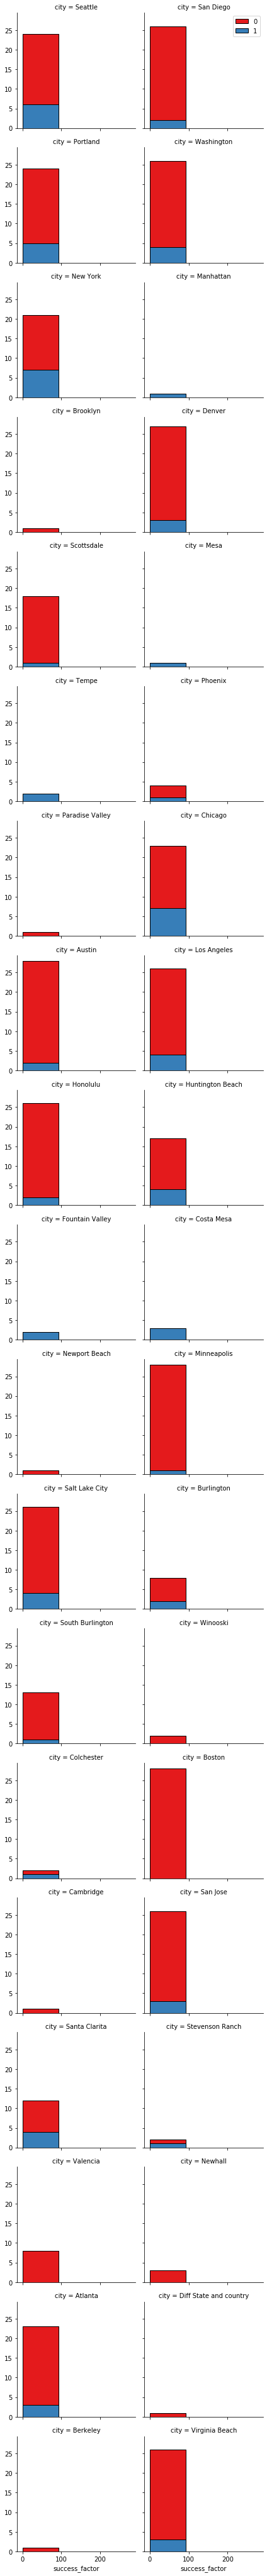

In [98]:
#Fitness Centers in the captured cities
bins = np.linspace(df_fitness_US.likes_count.min(), df_fitness_US.likes_count.max(), 4)
g = sns.FacetGrid(df_fitness_US, col="city", hue="success_factor", palette="Set1", col_wrap=2)
g.map(plt.hist, 'success_factor', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

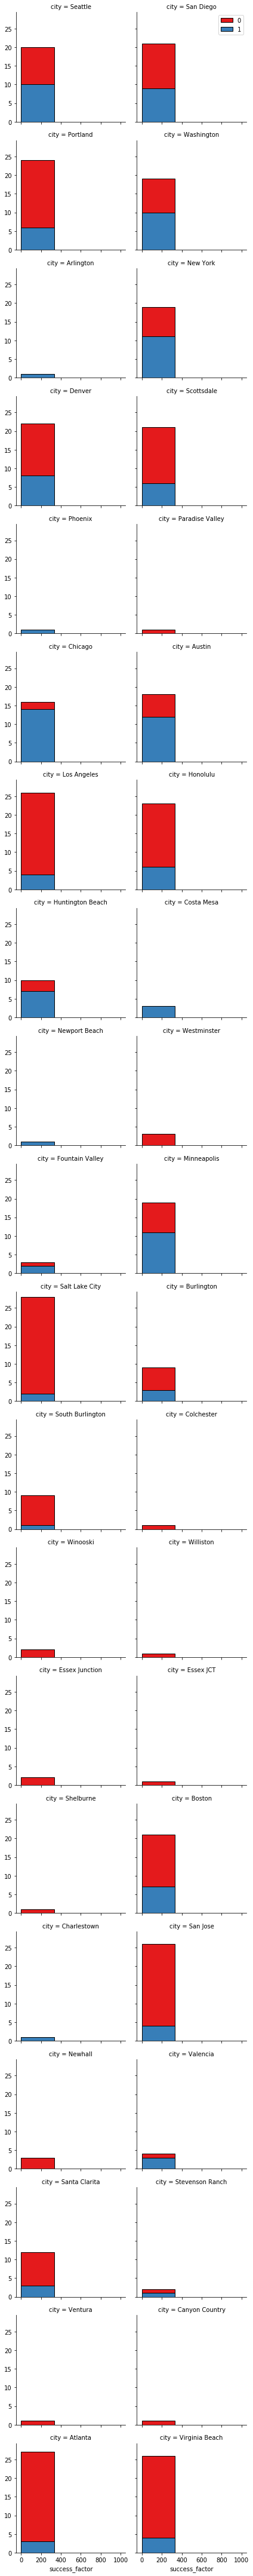

In [97]:
#Restaurants in the captured cities
bins = np.linspace(df_restaurants_US.likes_count.min(), df_restaurants_US.likes_count.max(), 4)
g = sns.FacetGrid(df_restaurants_US, col="city", hue="success_factor", palette="Set1", col_wrap=2)
g.map(plt.hist, 'success_factor', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

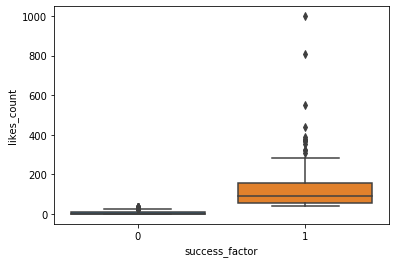

In [79]:
#What does the success factor look like for restaurants in these cities
sns.boxplot(x="success_factor", y="likes_count", data=df_restaurants_US)

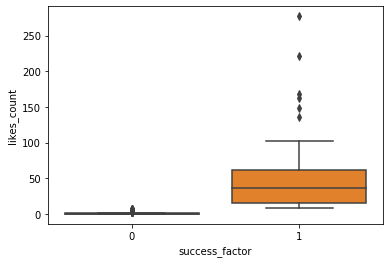

In [80]:
#What does the success factor look like for fitness centers in these cities
sns.boxplot(x="success_factor", y="likes_count", data=df_fitness_US)

In [85]:
# What cities have highest like_counts for fitness centers
fitness_check = df_fitness_US[df_fitness_US['success_factor']==1]
fitness_check.sort_values(by='likes_count', ascending=False)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,likes_count,success_factor
138,Crunch Fitness - Union Square,Gym / Fitness Center,113 4th Avenue,NaN,40.732673,-73.989949,"[{'label': 'display', 'lat': 40.73267299331333...",2601,10003,US,New York,NY,United States,"[113 4th Avenue, New York, NY 10003, United St...",NaN,49bad9acf964a520b8531fe3,277.0,1
141,Blink Fitness,Gym,16 E 4th St,btwn Broadway & Lafayette St,40.727869,-73.993562,"[{'label': 'display', 'lat': 40.72786868539725...",1986,10012,US,New York,NY,United States,"[16 E 4th St (btwn Broadway & Lafayette St), N...",NaN,4cbe5493611abfb717f5a405,222.0,1
216,Fitness Formula Club (FFC),Gym,10 S Clinton St,btwn Monroe St. & Madison St.,41.881485,-87.641517,"[{'label': 'display', 'lat': 41.88148544390432...",1562,60661,US,Chicago,IL,United States,[10 S Clinton St (btwn Monroe St. & Madison St...,NaN,4b44a9e3f964a520dff825e3,168.0,1
214,XSport Fitness,Gym,819 S State St,btwn 8th St & 9th St,41.871273,-87.627628,"[{'label': 'display', 'lat': 41.87127309277345...",546,60605,US,Chicago,IL,United States,"[819 S State St (btwn 8th St & 9th St), Chicag...",NaN,49d818b6f964a520a55d1fe3,162.0,1
554,LA Fitness,Gym,75 5th St NW Ste E,at Spring St,33.777394,-84.389016,"[{'label': 'display', 'lat': 33.77739445839471...",3151,30308,US,Atlanta,GA,United States,"[75 5th St NW Ste E (at Spring St), Atlanta, G...",NaN,4b8f9eb9f964a520385a33e3,148.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,Fitness Center At Omni Hotel,Gym,NaN,NaN,33.759016,-84.394619,"[{'label': 'display', 'lat': 33.75901555953395...",1177,30313,US,Atlanta,GA,United States,"[Atlanta, GA 30313, United States]",NaN,504a5f53e4b073cb14f4fea6,8.0,1
75,9Round Fitness,Gym / Fitness Center,906 NW 14th Avenue,NW Kearney,45.529475,-122.685302,"[{'label': 'display', 'lat': 45.52947545161572...",1343,97209,US,Portland,OR,United States,"[906 NW 14th Avenue (NW Kearney), Portland, OR...",NaN,5362d7fa498e0a01d67ef7ad,8.0,1
341,Fitness 19,Gym / Fitness Center,19111 Beach Boulevard,at Garfield,33.685177,-117.989850,"[{'label': 'display', 'lat': 33.68517723, 'lng...",1211,92648,US,Huntington Beach,CA,United States,"[19111 Beach Boulevard (at Garfield), Huntingt...",NaN,524548fc8bbd1bf109286136,8.0,1
363,Anytime Fitness,Gym / Fitness Center,111 Washington Ave N Ste 100,NaN,44.983080,-93.270920,"[{'label': 'display', 'lat': 44.98308, 'lng': ...",773,55401,US,Minneapolis,MN,United States,"[111 Washington Ave N Ste 100, Minneapolis, MN...",NaN,4e407a95c65b4f2fdeac7f39,8.0,1


In [86]:
#What are the top cities for 'successful' restaurants
restaurants_check = df_restaurants_US[df_restaurants_US['success_factor']==1]
restaurants_check.sort_values(by='likes_count', ascending=False)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,likes_count,success_factor
133,Jing Fong Restaurant 金豐大酒樓,Dim Sum Restaurant,20 Elizabeth St,btwn Bayard & Canal St,40.715881,-73.997209,"[{'label': 'display', 'lat': 40.7158812029412,...",821,10013,US,New York,NY,United States,"[20 Elizabeth St (btwn Bayard & Canal St), New...",NaN,3fd66200f964a520d5e31ee3,999.0,1
131,Golden Unicorn Restaurant 麒麟金閣,Dim Sum Restaurant,18 E Broadway,at Catherine St,40.713629,-73.997230,"[{'label': 'display', 'lat': 40.71362850464683...",748,10002,US,New York,NY,United States,"[18 E Broadway (at Catherine St), New York, NY...",NaN,3fd66200f964a520ece31ee3,810.0,1
240,Iron Cactus Mexican Restaurant and Margarita Bar,Mexican Restaurant,606 Trinity St,at E 6th St,30.267340,-97.739410,"[{'label': 'display', 'lat': 30.26734, 'lng': ...",589,78701,US,Austin,TX,United States,"[606 Trinity St (at E 6th St), Austin, TX 7870...",NaN,40b13b00f964a520b1f31ee3,553.0,1
472,Toro Restaurant,Tapas Restaurant,1704 Washington Street,at Massachusetts Ave,42.336988,-71.075924,"[{'label': 'display', 'lat': 42.33698788, 'lng...",2968,02118,US,Boston,MA,United States,[1704 Washington Street (at Massachusetts Ave)...,NaN,43e9e7eff964a520202f1fe3,442.0,1
183,Olive & Ivy Restaurant + Marketplace,Mediterranean Restaurant,7135 E Camelback Rd Ste 195,Scottsdale Waterfront,33.500098,-111.928382,"[{'label': 'display', 'lat': 33.50009772106360...",690,85251,US,Scottsdale,AZ,United States,[7135 E Camelback Rd Ste 195 (Scottsdale Water...,NaN,47fe99e7f964a520e84e1fe3,387.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Bangkok Joe's Thai Restaurant & Dumpling Bar,Thai Restaurant,3000 K St NW,Thomas Jefferson St,38.902270,-77.060061,"[{'label': 'display', 'lat': 38.90226978423286...",2190,20007,US,Washington,D.C.,United States,"[3000 K St NW (Thomas Jefferson St), Washingto...",NaN,4a8ec895f964a520a01220e3,41.0,1
275,"24/7 Restaurant at The Standard, Downtown LA",American Restaurant,550 S Flower St,6th St. At The Standard Hotel,34.049743,-118.256548,"[{'label': 'display', 'lat': 34.04974294912817...",1344,90071,US,Los Angeles,CA,United States,[550 S Flower St (6th St. At The Standard Hote...,Financial District,4b87b6a5f964a5204dc831e3,40.0,1
421,Ruben James,Sports Bar,159 Main St,btwn Church St & Saint Paul St,44.475936,-73.212858,"[{'label': 'display', 'lat': 44.47593564403017...",67,05401,US,Burlington,VT,United States,"[159 Main St (btwn Church St & Saint Paul St),...","Downtown Burlington, Burlington, VT",4b2ad938f964a520c4b024e3,40.0,1
304,Yu Chun Korean Restaurant,Korean Restaurant,1159 Kapiolani Blvd,NaN,21.295625,-157.848796,"[{'label': 'display', 'lat': 21.29562493521150...",1222,96814,US,Honolulu,HI,United States,"[1159 Kapiolani Blvd, Honolulu, HI 96814, Unit...",NaN,4b6a500ff964a520d1d12be3,39.0,1


#### Prep for clustering 
 1. set up by success equal to True or False


In [57]:
# merge the two dataframes 
df_merged = df_restaurants_US.append(df_fitness_US)
df_merged = df_merged[df_merged['success_factor']==1]
df_merged.shape

(234, 18)

In [99]:
df_merged_groups = df_merged.groupby(['city']).count()
df_merged_groups.sort_values(by=['name'], ascending=False)



,Cluster_Labels,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,state,country,formattedAddress,neighborhood,id,likes_count,success_factor
city,,,,,,,,,,,,,,,,,,
Chicago,21,21,21,21,18,21,21,21,21,21,21,21,21,21,2,21,21,21
New York,18,18,18,18,14,18,18,18,18,17,18,18,18,18,0,18,18,18
Seattle,16,16,16,15,12,16,16,16,16,16,16,16,16,16,0,16,16,16
Washington,14,14,14,14,7,14,14,14,14,14,14,14,14,14,1,14,14,14
Austin,14,14,14,14,11,14,14,14,14,14,14,14,14,14,1,14,14,14
Minneapolis,12,12,12,12,10,12,12,12,12,12,12,12,12,12,0,12,12,12
Portland,11,11,11,11,10,11,11,11,11,11,11,11,11,11,1,11,11,11
Denver,11,11,11,10,10,11,11,11,11,11,11,11,11,11,2,11,11,11
Huntington Beach,11,11,11,11,9,11,11,11,11,11,11,11,11,11,1,11,11,11


### Cluster the cities. Prep for kMeans Clustering model

In [60]:
#prep for clusters, get latitude and longitude
cluster_prep = df_merged[['lat', 'lng']]
cluster_prep


,lat,lng
0,47.598377,-122.323382
1,47.596992,-122.324930
2,47.598584,-122.322439
5,47.608207,-122.340824
6,47.610821,-122.340689
...,...,...
14,33.777394,-84.389016
16,33.739858,-84.357973
13,36.848978,-76.036600
19,36.847325,-75.974274


In [38]:
## set up coordinates for US map
map_lat, map_lng = get_address('United States')
print(map_lat, map_lng)

39.7837304 -100.4458825


In [72]:
#This respresents the number of cities that have 'successful' restaurants and/or fitness centers
df_merged_groups.shape

(33, 17)

In [61]:
# set up for clustering - 33 cities 
kclusters = 33 #number of actual cities captured in the dataset with successful ventures


# run k-means cluster 
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_prep)
kmeans.labels_

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4, 31, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 16, 16,  7,  7,  7,  7, 30,  7,  7, 30, 30,
        7, 30, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  8,
        8,  8,  8,  8,  1,  1,  1,  1,  1,  1, 28,  3,  3,  3, 27,  3, 27,
        3, 27, 27,  3,  3,  3, 27,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5, 19, 19, 19, 19,  2,  2,  2,  2,  2,  2, 26, 26, 26, 18,
       26, 18, 24, 24, 20, 20, 18, 20, 20,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9, 11, 11,  0,  0,  0,  0, 12, 12, 12, 12, 12, 12, 12, 12,
       14, 14, 14, 14,  6,  6,  6,  6,  6,  6,  6, 10, 10, 10, 17, 17, 17,
       17,  4,  4,  4,  4,  4,  4, 15, 15, 16, 16, 16, 16, 16,  7, 30,  7,
        7, 13, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  1, 21, 28, 25, 25,
       27, 27,  3, 27,  3,  3,  3,  5,  5, 19, 19, 19, 32,  2,  2, 26, 18,
       26, 24, 18, 24, 24, 20, 20,  9, 11, 11, 11, 11,  0,  0, 29,  0, 14,
       14, 14,  6, 22, 22

In [62]:
#remove Clusterlabels. Used for having to re fit the kMeans cluster
df_venues_cluster_labels.drop(['Cluster_Labels'], axis=1, inplace=True)
df_venues_cluster_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 29
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1200 non-null   object 
 1   categories        1181 non-null   object 
 2   address           992 non-null    object 
 3   crossStreet       399 non-null    object 
 4   lat               1200 non-null   float64
 5   lng               1200 non-null   float64
 6   labeledLatLngs    1198 non-null   object 
 7   distance          1200 non-null   object 
 8   postalCode        1078 non-null   object 
 9   cc                1200 non-null   object 
 10  city              1187 non-null   object 
 11  state             1200 non-null   object 
 12  country           1200 non-null   object 
 13  formattedAddress  1200 non-null   object 
 14  neighborhood      30 non-null     object 
 15  id                1200 non-null   object 
 16  likes_count       1200 non-null   float64
 1

In [63]:
#add clustering labels to dataframe
df_venues_cluster_labels = df_merged
df_venues_cluster_labels.insert(0, 'Cluster_Labels', kmeans.labels_)
df_venues_cluster_labels.head()

,Cluster_Labels,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,likes_count,success_factor
0,4,Harbor City Restaurant,Chinese Restaurant,707 S King St,at 7th Ave S,47.598377,-122.323382,"[{'label': 'display', 'lat': 47.59837711767561...",787,98104,US,Seattle,WA,United States,"[707 S King St (at 7th Ave S), Seattle, WA 981...",NaN,4b2d2a7cf964a520facf24e3,145.0,1
1,4,Bush Garden Restaurant,Karaoke Bar,614 Maynard Ave S,NaN,47.596992,-122.324930,"[{'label': 'display', 'lat': 47.59699150849453...",853,98104,US,Seattle,WA,United States,"[614 Maynard Ave S, Seattle, WA 98104, United ...",NaN,428d2880f964a520b1231fe3,43.0,1
2,4,Green Leaf Vietnamese Restaurant,Vietnamese Restaurant,418 8th Ave S,at S King St,47.598584,-122.322439,"[{'label': 'display', 'lat': 47.59858422766606...",817,98104,US,Seattle,WA,United States,"[418 8th Ave S (at S King St), Seattle, WA 981...",NaN,4766fc4ff964a520f04c1fe3,114.0,1
5,4,Maximilien Restaurant,French Restaurant,81A Pike St Ste A,NaN,47.608207,-122.340824,"[{'label': 'display', 'lat': 47.60820684827345...",943,98101,US,Seattle,WA,United States,"[81A Pike St Ste A, Seattle, WA 98101, United ...",NaN,4846c47ff964a5206e501fe3,73.0,1
6,4,Long Provincial Vietnamese Restaurant,Vietnamese Restaurant,1901 2nd Ave,at Stewart St,47.610821,-122.340689,"[{'label': 'display', 'lat': 47.61082072245036...",1114,98101,US,Seattle,WA,United States,"[1901 2nd Ave (at Stewart St), Seattle, WA 981...",NaN,49ed594df964a520e3671fe3,114.0,1


In [100]:
# create map
us_map_clusters = folium.Map(location=[map_lat, map_lng], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_venues_cluster_labels['lat'], df_venues_cluster_labels['lng'], df_venues_cluster_labels['name'] + ' ' + df_venues_cluster_labels['city'], df_venues_cluster_labels['Cluster_Labels']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(us_map_clusters)
       
us_map_clusters